# 2a_Modelling

In [2]:
import pandas as pd
import os
from pycaret.classification import *

### Importing train and test data

Features are sorted into lists for easier selection

In [6]:
train_data = pd.read_csv('../assets/data_sh/train_v3.csv')
test_data = pd.read_csv('../assets/data_sh/test_v3.csv')

response = ['WnvPresent']
cat_features = ['Species']
num_features = sorted(list(set(train_data.columns) - set(cat_features)- set(response)))


### Notes on preprocessing 

- Numerical features scaled with StandardScaler. Technically, gradient boosted trees do not require scaling but the scaling allows for more consistent benchmarking against models that do.

- Categorical features one-hot encoded. There are more efficient ways to do this, especially with some of the new gradient boosted methods. In practice, there was not much differnce in performance as there is only one categorical feature.

- Missing values are imputed iteratively with LightGBM's impute method - most ensemble decision tree methods can do this but LightGBM's impute method is a bit faster.

- Class imbalance is handled with SMOTE as the class imbalance is quite extreme, WnvPresent is the extreme minority class.


In [4]:
s = setup(data=train_data,
          target='WnvPresent',
          ignore_features=None,
          numeric_features=num_features,
          categorical_features=cat_features,
          imputation_type='iterative',          # iterative imputation of missing values in numeric features with lightgbm
          train_size=0.9,
          normalize=True,                       # default is normalization
          fix_imbalance=True,                   # use SMOTE
          # required for an imbalanced classification problem
          data_split_stratify=True,
          use_gpu=True,
          n_jobs=-1,
          session_id=42,
          silent=True)


,Description,Value
0,session_id,42
1,Target,WnvPresent
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(6854, 42)"
5,Missing Values,True
6,Numeric Features,40
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [5]:
best_model = compare_models(sort = 'AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8019,0.8052,0.5909,0.2140,0.3139,0.2270,0.2673,2.9050
lr,Logistic Regression,0.6824,0.8036,0.8012,0.1687,0.2786,0.1742,0.2619,0.3420
lightgbm,Light Gradient Boosting Machine,0.8747,0.8032,0.3346,0.2589,0.2905,0.2235,0.2263,0.8140
catboost,CatBoost Classifier,0.8782,0.8002,0.3495,0.2763,0.3063,0.2413,0.2443,7.1080
ada,Ada Boost Classifier,0.7704,0.7974,0.6355,0.1950,0.2983,0.2052,0.2565,0.7340
xgboost,Extreme Gradient Boosting,0.8852,0.7944,0.2711,0.2640,0.2657,0.2040,0.2047,0.6590
lda,Linear Discriminant Analysis,0.6624,0.7909,0.8075,0.1609,0.2682,0.1612,0.2504,0.0960
rf,Random Forest Classifier,0.8649,0.7722,0.3283,0.2326,0.2710,0.1994,0.2035,0.8300
qda,Quadratic Discriminant Analysis,0.5871,0.7709,0.8413,0.1477,0.2497,0.1374,0.2208,0.0660
nb,Naive Bayes,0.5713,0.7310,0.8179,0.1313,0.2262,0.1087,0.1963,0.0420


### Model evaluation

Model accuracy is evaluated using the ROC-AUC metric, which is a more appropriate metric for problems with class imbalance. The theoretical baseline ROC-AUC score is 0.5, also exemplified by the score of the Dummy Classifier.

The ROC-AUC score is the main criterion for model selection. Training time was considered but later deprioritized, as the task does not require real-time performance or close synergy with an ETL pipeline.

In this case, model interpretation could also considered be as a favorable criteria. However, even blackbox models like the Gradient Boosting Classifier and Light Gradient Boosting Machine can have feature importance extracted with SHAP methods.

Under these considerations - the Gradient Boosting Classifier was selected as the chosen model with the best ROC-AUC score. 



In [6]:
model = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7877,0.8058,0.5745,0.1957,0.2919,0.2011,0.2417
1,0.8006,0.8013,0.5106,0.1935,0.2807,0.1914,0.2219
2,0.8217,0.7797,0.5957,0.2353,0.3373,0.2561,0.2932
3,0.8104,0.8261,0.6170,0.2266,0.3314,0.2476,0.2900
4,0.8039,0.8363,0.5957,0.2154,0.3164,0.2303,0.2711
5,0.7844,0.8037,0.6383,0.2055,0.3109,0.2211,0.2714
6,0.7974,0.7849,0.5417,0.2016,0.2938,0.2035,0.2375
7,0.8201,0.8321,0.7292,0.2632,0.3867,0.3076,0.3628
8,0.8182,0.8343,0.5745,0.2269,0.3253,0.2424,0.2776


This workflow leverages the Optuna framework, which is an automatic hyperparameter optimization framework that is conveniently integrated within Pycaret. It significantly reduces the size of the hyperparameter space to be explored.

In [7]:
model = tune_model(model, optimize='AUC', tuner_verbose=False, search_library='optuna')
print(model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7472,0.8032,0.6809,0.1850,0.2909,0.1944,0.2560
1,0.7358,0.8130,0.6809,0.1778,0.2819,0.1833,0.2458
2,0.7504,0.7587,0.6383,0.1796,0.2804,0.1833,0.2376
3,0.7699,0.8504,0.8085,0.2222,0.3486,0.2602,0.3409
4,0.7358,0.8457,0.7447,0.1882,0.3004,0.2036,0.2773
5,0.7439,0.8096,0.7021,0.1864,0.2946,0.1981,0.2636
6,0.7310,0.7987,0.6458,0.1722,0.2719,0.1700,0.2263
7,0.7601,0.8395,0.7917,0.2159,0.3393,0.2473,0.3257
8,0.7760,0.8194,0.6809,0.2065,0.3168,0.2262,0.2843


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=3.878982723500337e-06, loss='deviance',
                           max_depth=8, max_features=0.4973786082366074,
                           max_leaf_nodes=None,
                           min_impurity_decrease=2.7473812930582237e-08,
                           min_impurity_split=None, min_samples_leaf=4,
                           min_samples_split=7, min_weight_fraction_leaf=0.0,
                           n_estimators=134, n_iter_no_change=None,
                           presort='deprecated', random_state=42,
                           subsample=0.24575365786376466, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


A ROC curve is presented to show the tradeoff between the true positive rate and the false positive rate for different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives.

"Elbows" of the curve are points where the classification threshold may be optimal for a specific tradeoff between the true positive rate and the false positive rate.

The selection of the optimal threshold is out of scope for this project as the costs of false positives and false negatives have not been considered. But it certainly remains as an option for future work.


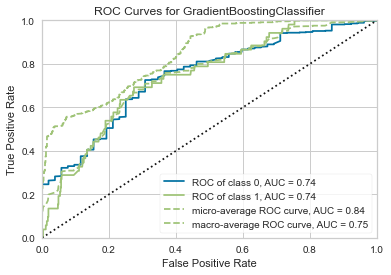

In [8]:
plot_model(model, plot = 'auc')

### Feature Importance 

Feature importance are derived using SHAP. Note that the SHAP-derived feature importance are not an indication of causative relationships. 

Additionally, while the plot expresses the magnitude of feature importance, the plot does not show the direction of the features effect on the model output. 


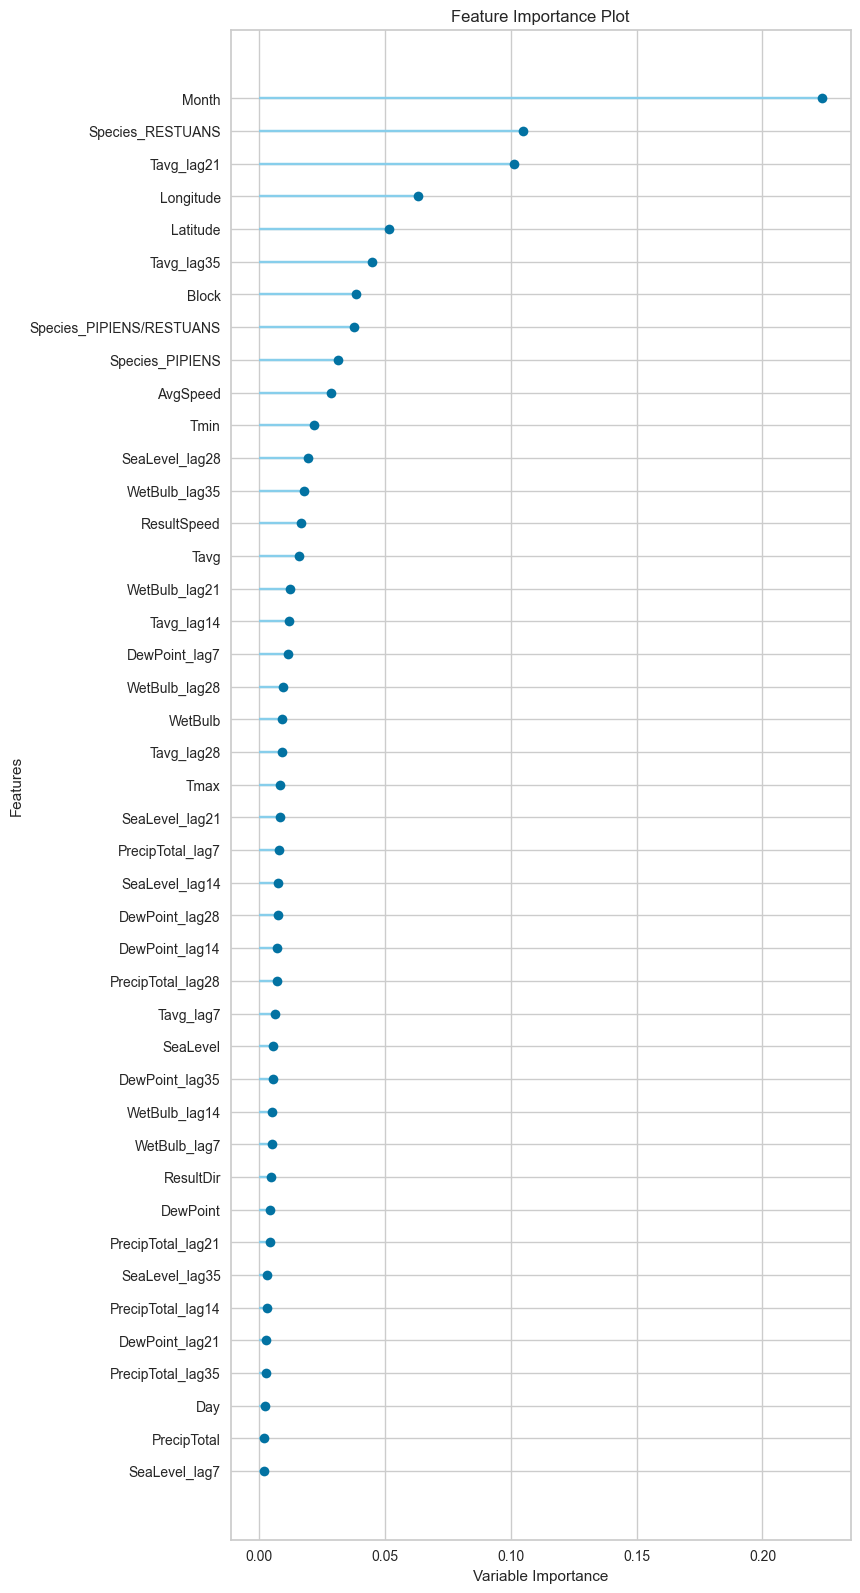

In [28]:
plot_model(model, plot = 'feature_all')

### Prototype Model Performance on Validation and Test Data

Pycaret's setup function has set aside a portion of the data for validation. The model was not trained or tuned on this validation data. 

Train Score (AUC) = 0.8110
Test Score (AUC) = 0.7438

The model is overfitting to the training data. The performance on the test (Kaggle) data is very likely to be poor as well.

In [30]:
predict_model(model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7201,0.7438,0.6923,0.1698,0.2727,0.1719,0.2375


,Block,Latitude,Longitude,Month,Day,Tmax,Tmin,Tavg,DewPoint,WetBulb,...,DewPoint_lag35,WetBulb_lag35,PrecipTotal_lag35,SeaLevel_lag35,Species_PIPIENS,Species_PIPIENS/RESTUANS,Species_RESTUANS,WnvPresent,Label,Score
0,1.653559,1.572246,0.154731,-0.671529,-1.069759,0.388587,-0.382133,-0.014992,-0.804599,-0.432712,...,-0.315578,-0.541161,1.254086,-0.582959,0.0,1.0,0.0,0,0,0.5003
1,0.962116,1.312025,0.366646,0.305356,-0.841717,-0.505362,0.377053,-0.085309,-0.610506,-0.509334,...,0.364926,0.315271,-0.546522,0.683388,0.0,1.0,0.0,0,1,0.5001
2,0.962116,1.290688,-0.243019,-0.671529,1.096637,-0.186094,-0.934268,-0.577532,-0.933995,-0.739200,...,0.103194,0.254097,-0.546522,1.067141,0.0,1.0,0.0,0,0,0.5003
3,0.270673,1.030698,-0.951040,0.305356,-0.955738,-1.080043,0.170002,-0.507215,-0.157622,-0.356090,...,-0.053846,0.009402,-0.546522,0.721771,0.0,1.0,0.0,0,0,0.5002
4,-0.258078,0.835672,0.034095,-1.648415,-1.525842,-2.804086,-2.107555,-2.616742,-1.775065,-2.271637,...,-3.351676,-3.355152,-0.546522,1.949750,0.0,0.0,1.0,0,0,0.5003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,-0.908848,-1.397197,1.013268,1.282241,-1.183779,1.027122,0.653121,0.899137,0.295262,0.563372,...,0.626659,0.927008,-0.546522,0.222900,1.0,0.0,0.0,0,1,0.5001
682,-0.990194,1.057533,-2.220739,-1.648415,1.552720,-0.633069,-0.037048,-0.366579,-0.804599,-0.662578,...,-1.257816,-1.214072,-0.376385,0.376401,0.0,1.0,0.0,0,0,0.5003
683,1.328174,-0.549133,0.005482,-1.648415,1.324679,1.027122,0.100985,0.617867,0.748146,0.639994,...,-1.571895,-2.009330,-0.291317,0.683388,0.0,0.0,1.0,0,0,0.5003
684,1.450193,1.493550,-0.725788,0.305356,0.640554,0.452440,0.653121,0.547549,1.265728,1.023103,...,0.940738,0.865834,-0.234605,-0.506208,0.0,1.0,0.0,1,1,0.5001


### Model blending 

To deal with overfitting - the Gradient Boosting Classifier can continue to be tuned (by restricting tree growth using hyperparameter tuning).

However, the preferred approach by the team is model blending which combines the performance of multiple models. In testing, this yielded significantly better performance than just tuning for a single model.

Under the hood, the model blending is implemented with sklearn's VotingClassifier.

_"The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses."_

The top three models are selected for blending. The selection of the models is not arbitrary but is based on the different strategies that each model uses:

1. The Gradient Boosting Classifier (GBC) was selected as the first model for strong AUC performance.   

2. Light Gradient Boosting Machine, another gradient boosting decision tree (GBDT) algorithm was also selected. A second GBDT algorithm might seem superfluous, but LightGBM relies of leaf-wise tree growth, resulting in mostly asymmetrical trees. It has a different learning strategy and could help to balance out the GBC weaknesses in a blended model.

3. Logistic Regression was selected as the final model. This model is a parametric linear model which assumes simple linear relationships between each feature and the response. On first impressions it seems like this would be a poor choice because features like Longitude and Latitude are definitely not linearly related to the response. However, the hunch is that the other weather-related features share a stronger linear relationship with the response. It is possible that the logistic regression can _"learn"_ the weather-related features better than tree-based models.

A fourth model, the Random Forest Classifier, was initially selected because it relied on bagging (a perturb and combine technique), which is conceptually different from the first 3 models. However, in testing, the performance gain was too small to justify training and tuning an additional model.

In [16]:
gbc = create_model('gbc', verbose = False)
lr = create_model('lr', verbose = False)
lightgbm = create_model('lightgbm', verbose = False)


In [17]:
blend_model = blend_models(estimator_list=[gbc, lr, lightgbm],
                           method='soft', choose_better=True,
                           optimize='AUC')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8169,0.8144,0.5745,0.2250,0.3234,0.2402,0.2757
1,0.8282,0.8139,0.5319,0.2294,0.3205,0.2396,0.2675
2,0.8266,0.7804,0.5532,0.2321,0.3270,0.2461,0.2769
3,0.8412,0.8496,0.6170,0.2661,0.3718,0.2970,0.3316
4,0.8412,0.8497,0.6383,0.2703,0.3797,0.3054,0.3427
5,0.8282,0.8162,0.5532,0.2342,0.3291,0.2487,0.2791
6,0.8169,0.7833,0.5208,0.2174,0.3067,0.2213,0.2494
7,0.8460,0.8429,0.6250,0.2804,0.3871,0.3133,0.3464
8,0.8312,0.8327,0.5106,0.2286,0.3158,0.2352,0.2600


In [31]:
blend_model = tune_model(blend_model, optimize='AUC', tuner_verbose=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8104,0.8124,0.5745,0.2177,0.3158,0.2308,0.2676
1,0.8152,0.8155,0.5957,0.2276,0.3294,0.2463,0.2849
2,0.8152,0.7783,0.5957,0.2276,0.3294,0.2463,0.2849
3,0.8282,0.8508,0.6170,0.2479,0.3537,0.2748,0.3131
4,0.8298,0.8540,0.6809,0.2623,0.3787,0.3019,0.3483
5,0.8055,0.8144,0.5957,0.2171,0.3182,0.2325,0.2730
6,0.8088,0.7781,0.5417,0.2131,0.3059,0.2186,0.2508
7,0.8347,0.8419,0.6458,0.2672,0.3780,0.3011,0.3403
8,0.8182,0.8299,0.5957,0.2314,0.3333,0.2510,0.2889


### Using the final model on test data

The final blended model is tested on the test set (Kaggle) and the AUC score is 0.76833. 

This significantly outperforms a single tuned GBC model which only scored 0.68240.

In [32]:
kaggle_pred_blend = predict_model(blend_model, data=test_data)

# predict a real-valued probability that WNV is present
def format_score(row):
    if row['Label'] == 1:
        pass
    elif row['Label'] == 0:
        row['Score'] = 1 - row['Score']
    return row

# formatting the submission file
kaggle_pred_blend = kaggle_pred_blend.apply(format_score, axis=1)
kaggle_pred_blend = kaggle_pred_blend.loc[:, ['Id', 'Score']].rename(columns={'Id': 'Id', 'Score': 'WnvPresent'})

# writing file to output folder
if not os.path.exists('output'):
    os.makedirs('output')
kaggle_pred_blend.to_csv('output/kaggle_blend2.csv', index=False)
